# Static Plots

Plotting results for dataset: stock_emotion


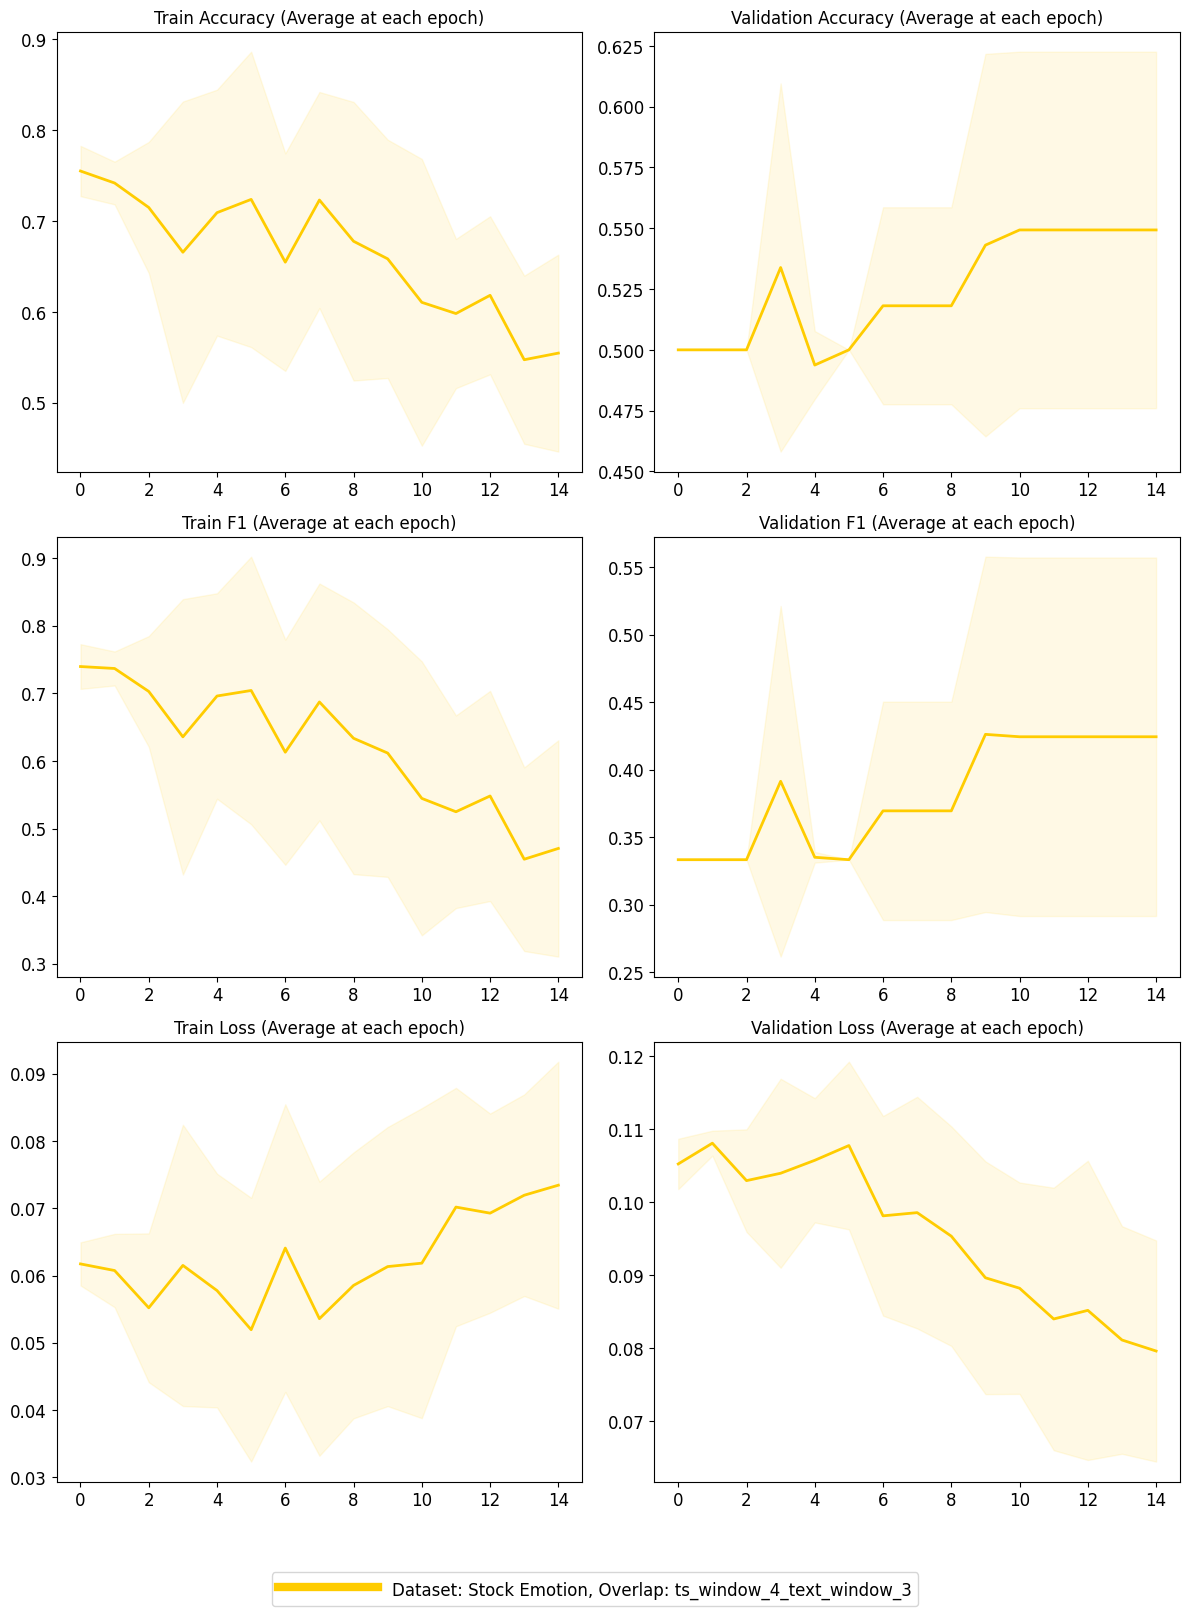

Plotting results for dataset: EDT


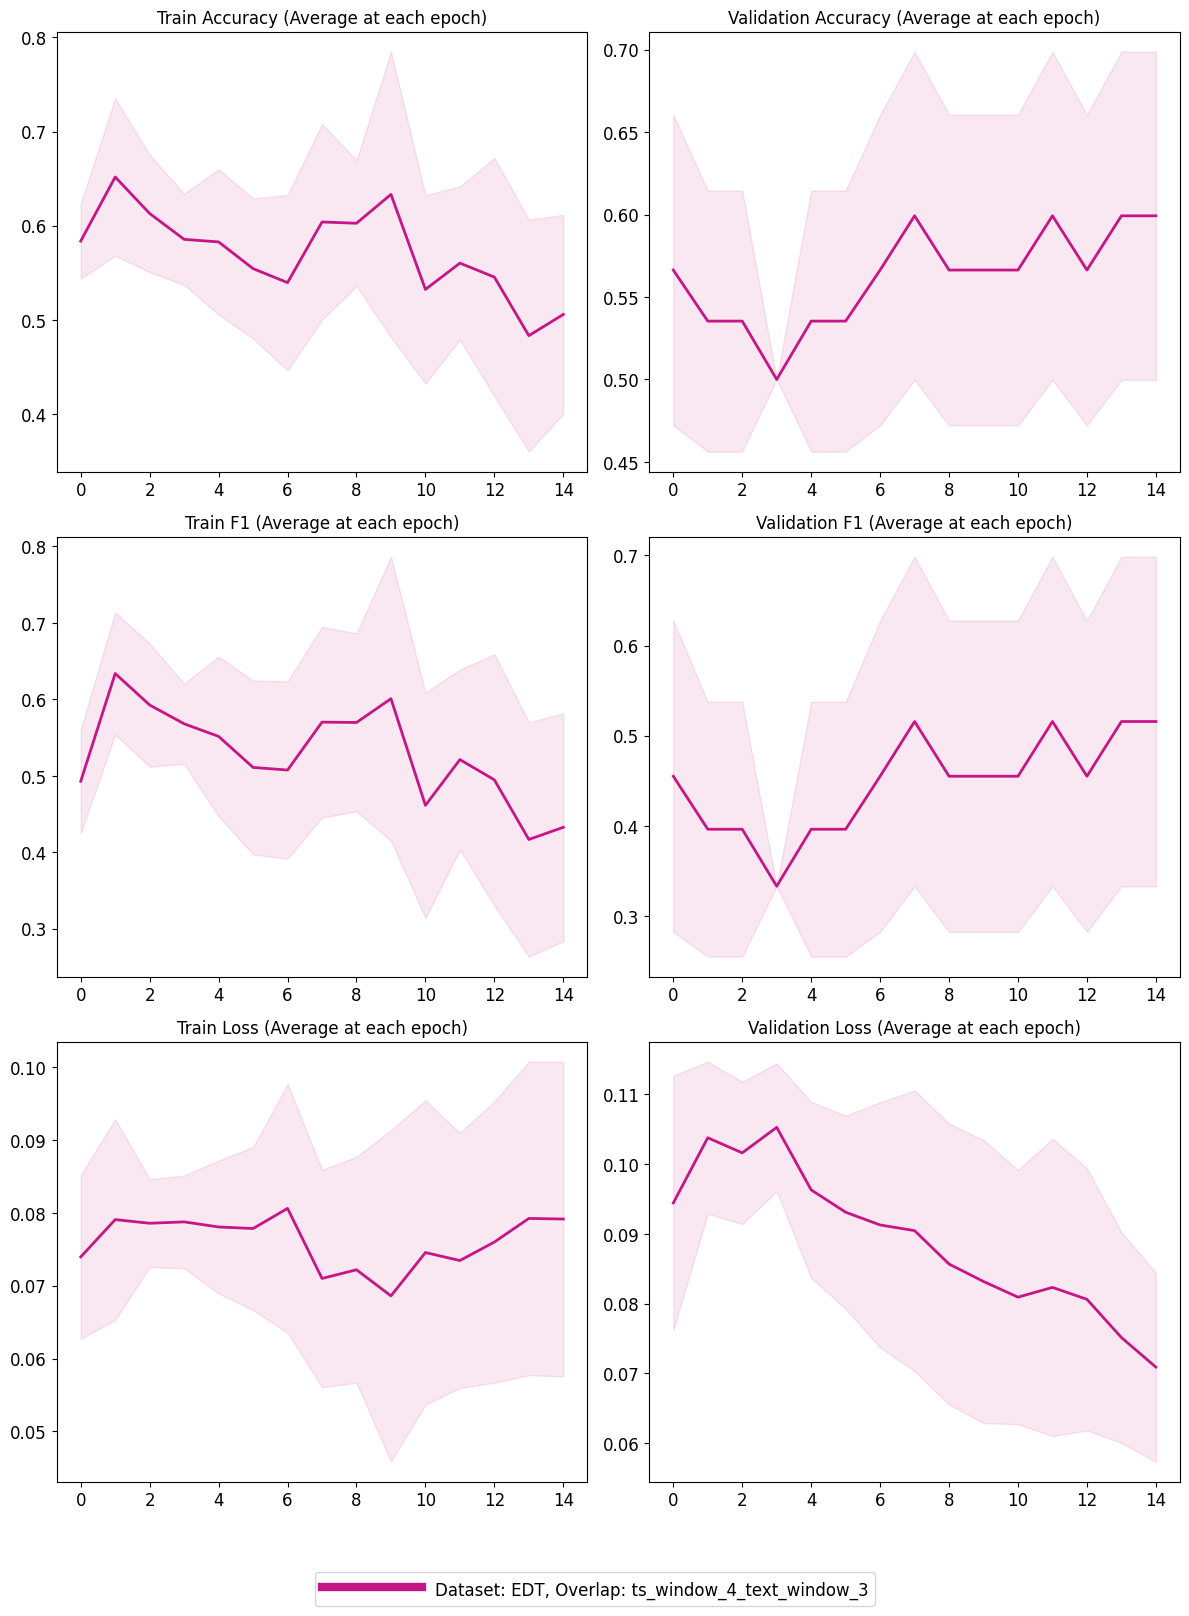

Plotting results for dataset: stock_net


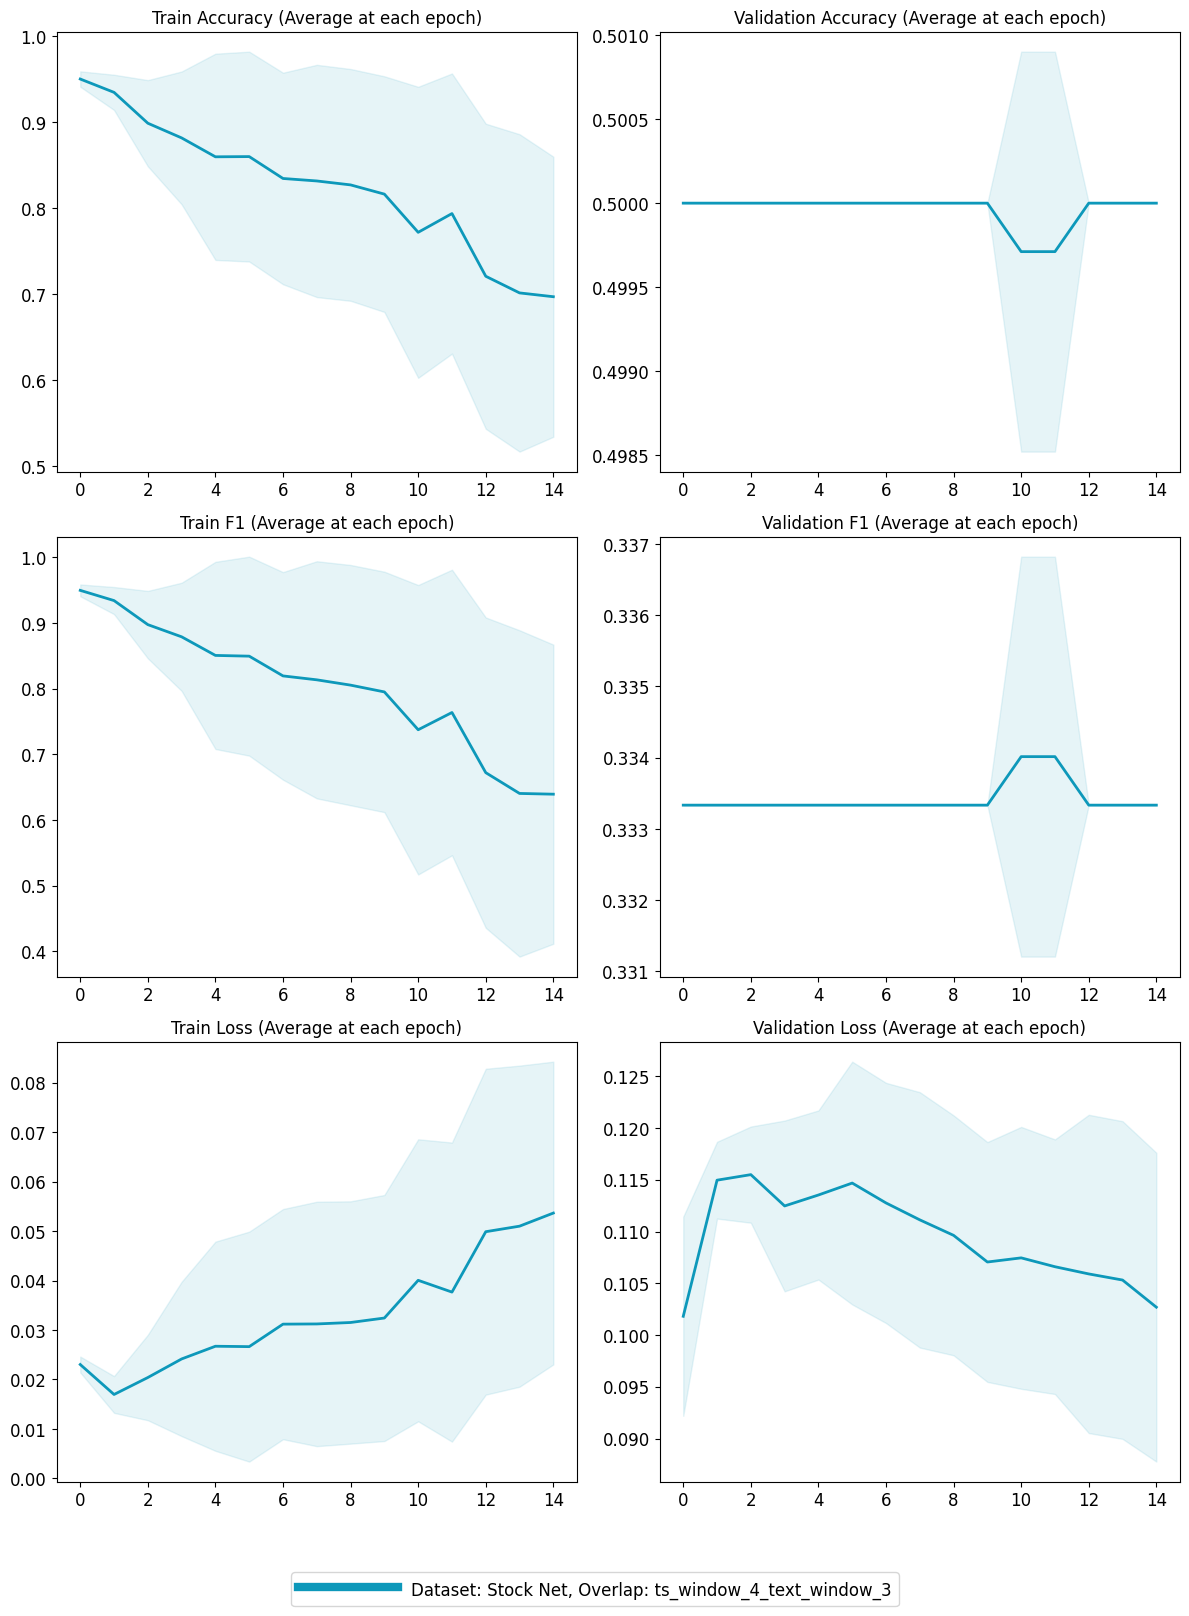

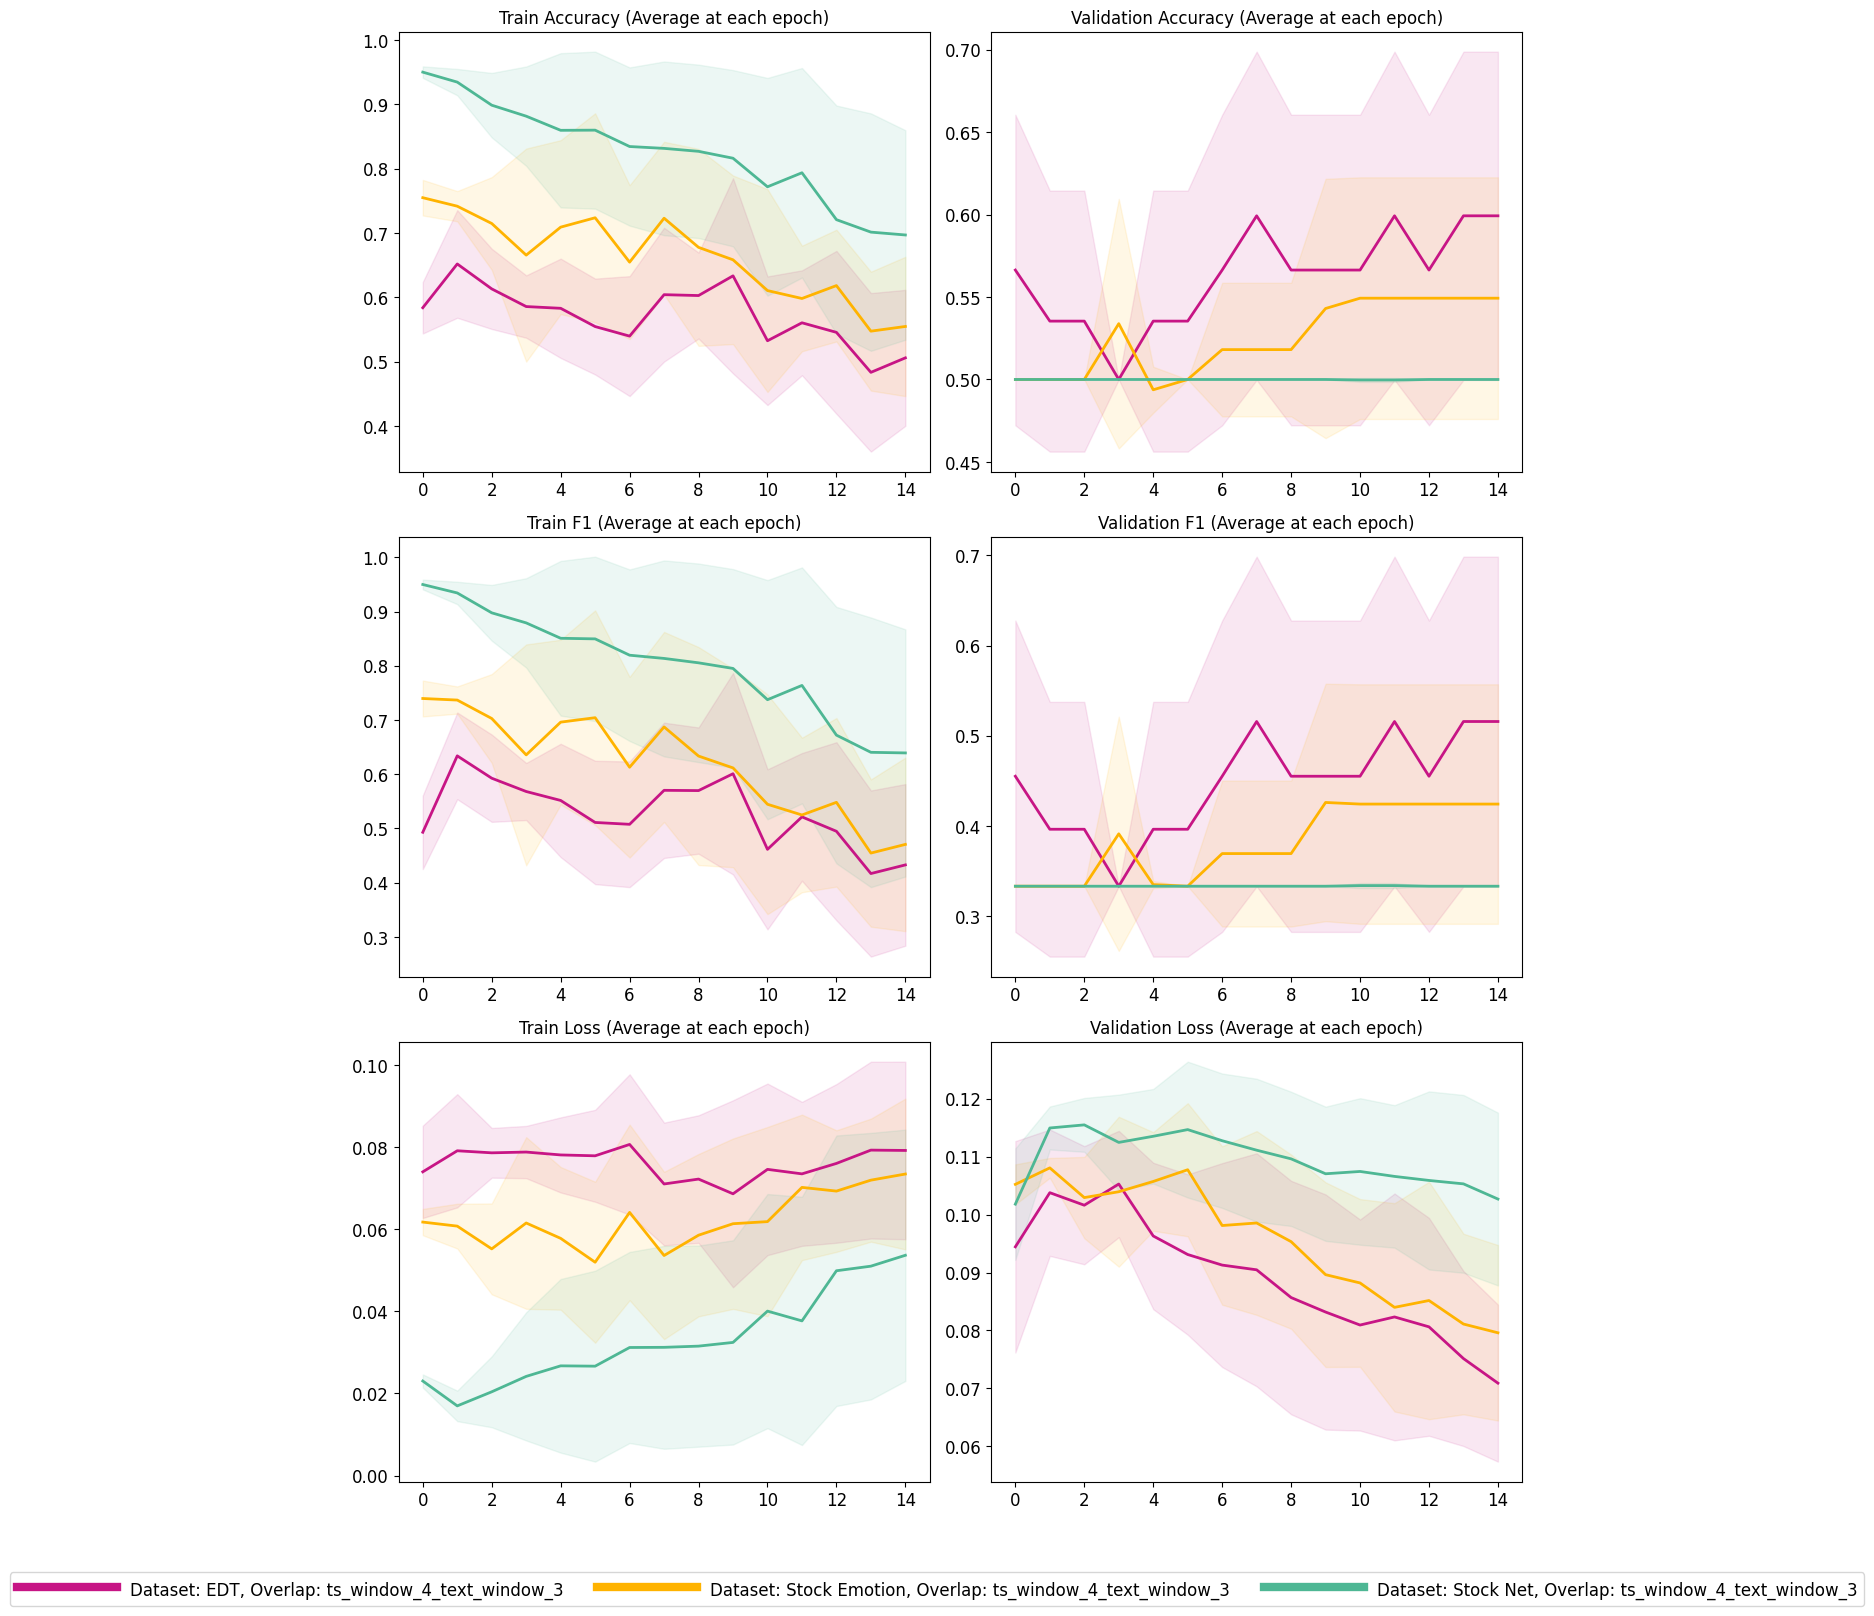

In [3]:
# Updating the plotting function to include legend based on dataset_name and text_aggregation_method
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

# Load the JSON file data
file_path = "./results/epsilon_transdis/final_training.json"
with open(file_path, "r") as file:
    data = json.load(file)




# Visualize confusion matrices for training and validation
def plot_confusion_matrices(data):
    for i, entry in enumerate(data[:3]):  # Limiting to first 3 examples for demonstration
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        train_conf_matrix = np.array(entry['train_metrics']['conf_matrix'][-1])
        val_conf_matrix = np.array(entry['val_metrics']['conf_matrix'][-1])

        sns.heatmap(train_conf_matrix, annot=True, fmt='d', ax=ax[0], cmap='Blues')
        ax[0].set_title(f'Train Confusion Matrix (Index {entry["search_index"]})')
        ax[0].set_xlabel('Predicted')
        ax[0].set_ylabel('True')

        sns.heatmap(val_conf_matrix, annot=True, fmt='d', ax=ax[1], cmap='Blues')
        ax[1].set_title(f'Validation Confusion Matrix (Index {entry["search_index"]})')
        ax[1].set_xlabel('Predicted')
        ax[1].set_ylabel('True')

        plt.tight_layout()
        plt.show()


# Calculate mean, variance, and standard deviation
def compute_run_stats(runs):
    stats = {}
    
    metrics = ['accuracy', 'f1', 'loss']
    
    for metric in metrics:
        train_values = np.array([entry['train_metrics'][metric] for entry in runs])
        val_values = np.array([entry['val_metrics'][metric] for entry in runs])
        
        stats[f'train_{metric}_mean'] = np.mean(train_values, axis=0)
        stats[f'train_{metric}_std'] = np.std(train_values, axis=0)
        stats[f'train_{metric}_var'] = np.var(train_values, axis=0)
        
        stats[f'val_{metric}_mean'] = np.mean(val_values, axis=0)
        stats[f'val_{metric}_std'] = np.std(val_values, axis=0)
        stats[f'val_{metric}_var'] = np.var(val_values, axis=0)
    
    return stats


import matplotlib.colors as mcolors

color_sets = {
    # Gradient from dark green to light green for 'stock_net'
    'stock_net': ['#0d98ba', '#2da7a7', '#4eb794', '#6ec681'],# '#8fd66e', '#b0e65b', '#d0f548', '#f1ff35', '#ffff1a', '#ffff00'],

    #['#0d98ba', '#2ea2a8', '#4fae95', '#70ba83', '#91c670', '#b2d25d', '#d3de4b', '#f4ea38', '#fce41e', '#adff2f'],

    #['#004d00', '#004d00', '#004d00', '#004d00',
     #              '#1a6600', '#1a6600', '#1a6600', '#1a6600', 
      #             '#338000', '#66b32d', '#99e64d'],  

    # Gradient from dark purple to light purple for 'EDT'
    'EDT': ['#c71585', '#b2198d', '#9e1d96', '#8a229e'],# '#7626a7', '#612aaf', '#4d2eb8', '#3932c0', '#2437c9', '#8a2be2'],
    #['#4B0082', '#4B0082', '#4B0082', '#4B0082',
    #         '#9370DB', '#9370DB', '#9370DB', '#9370DB', 
    #         '#6A0DAD', '#BA55D3', '#DDA0DD'],      

    # Gradient from dark orange to pale red for 'stock_emotion'
    'stock_emotion': ['#ffcc00', '#ffb300', '#ff9900', '#ff7f00'],# '#ff6600', '#ff4c00', '#ff3300', '#ff1900', '#ff0000', '#ff0000'],
        #['#ffcc00', '#ffb300', '#ff9900', '#ff7f00', '#ff6600', '#ff4c00', '#ff3300', '#ff1900', '#ff0000', '#ff0000'],
       #['#ffcc00', '#ffb800', '#ffa400', '#ff9100', '#ff7d00', '#ff6900', '#ff5500', '#ff4100', '#ff2d00', '#ff4500']
    
    #['#FF4500', '#FF4500', '#FF4500', '#FF4500',
    #                  '#FFB6C1', '#FFB6C1', '#FFB6C1', '#FFB6C1', 
    #                  '#FF6347', '#FFB6C1', '#FFDAB9']
}

# Function to select a color from predefined color sets based on the dataset
def get_color_variations_improved(base_dataset, num_variations, current_index):
    # Use the corresponding color set for the dataset
    color_list = color_sets[base_dataset]
    
    # If there are more variations than available colors, repeat colors
    # Select the color based on the index of the current parameter (current_index)
    return color_list[current_index % len(color_list)]

# Function to dynamically map line styles based on unique values of a parameter
def get_dynamic_line_styles(param_values):
    styles = ['-', '--', '-.', ':']
    unique_params = list(set(param_values))  # Get unique values of the parameter
    return {param: styles[i % len(styles)] for i, param in enumerate(unique_params)}

# Helper function to convert non-hashable types (lists, dicts) to tuples
def make_hashable(value):
    if isinstance(value, (list, dict)):
        return tuple(value)
    return value

# Adjusting the plot function to handle colors, line styles, and correct the legend dynamically
def plot_metrics_with_predefined_colors_and_styles(data, param_to_group_by='text_aggregation_method', font_size=12, line_width=2):
    # Group runs by dataset_name and the dynamic parameter to group by
    unique_runs = {}
    param_values = []
    

    for entry in data:
        dataset_name = entry['dataset_params']['data_source']['name']
        dynamic_param_value = make_hashable(entry['dataset_params'].get(param_to_group_by) or entry['model_params'].get(param_to_group_by))
        param_values.append(dynamic_param_value)
        run_key = (dataset_name, dynamic_param_value)
        
        if run_key not in unique_runs:
            unique_runs[run_key] = []
        
        unique_runs[run_key].append(entry)
    
    # Generate dynamic line styles based on the parameter to group by
    line_style_mapping = get_dynamic_line_styles(param_values)
    
    # Plot
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))

    legend_labels = []
    for idx, (run_key, runs) in enumerate(sorted(unique_runs.items(), key=lambda x: x[0])):  # Sort by dataset_name
        dataset_name, dynamic_param_value = run_key
        if dataset_name != 'EDT':
            dataset_name_title = dataset_name.replace("_", " ").title()
        else: dataset_name_title = dataset_name
        legend_label = f"Dataset: {dataset_name_title}, Overlap: {dynamic_param_value}"#, {specific}"#{dataset_name.replace("_", " ")} 
        
        # Get color variation from predefined list based on index of the run
        color = get_color_variations_improved(dataset_name, len(runs), idx)
        
        # Get line style based on dynamic parameter
        line_style = line_style_mapping.get(dynamic_param_value, '-')
        
        # Calculate mean and variance across runs with different random states
        stats = compute_run_stats(runs)
        
        for i, metric in enumerate(['accuracy', 'f1', 'loss']):
            # Train metrics
            axes[i, 0].plot(stats[f'train_{metric}_mean'], label=f'{legend_label} (Train)', color=color, linestyle=line_style, alpha=1, linewidth=line_width)
            axes[i, 0].fill_between(range(len(stats[f'train_{metric}_mean'])), 
                                    stats[f'train_{metric}_mean'] - stats[f'train_{metric}_std'],
                                    stats[f'train_{metric}_mean'] + stats[f'train_{metric}_std'], alpha=0.10, color=color)
            axes[i, 0].set_title(f'Train {metric.capitalize()} (Average at each epoch)', fontsize=font_size)
            axes[i, 0].tick_params(axis='both', which='major', labelsize=font_size)
            
            # Validation metrics
            axes[i, 1].plot(stats[f'val_{metric}_mean'], label=f'{legend_label} (Val)', color=color, linestyle=line_style, alpha=1, linewidth=line_width)
            axes[i, 1].fill_between(range(len(stats[f'val_{metric}_mean'])), 
                                    stats[f'val_{metric}_mean'] - stats[f'val_{metric}_std'],
                                    stats[f'val_{metric}_mean'] + stats[f'val_{metric}_std'], alpha=0.10, color=color)
            axes[i, 1].set_title(f'Validation {metric.capitalize()} (Average at each epoch)', fontsize=font_size)
            axes[i, 1].tick_params(axis='both', which='major', labelsize=font_size)
        
        # Collect unique legend labels for displaying later
        if legend_label not in legend_labels:
            legend_labels.append((legend_label, color, line_style))  # Add color and line style to legend labels

    # Adjust the layout
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave space at the bottom for the legend

    # Add one global legend at the bottom with correct colors and line styles
    handles = [plt.Line2D([0], [0], color=color, linestyle=line_style, label=label, linewidth=line_width + 4) for label, color, line_style in legend_labels]

    fig.legend(handles=handles, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.05), fontsize=font_size,
           handlelength=6, handleheight=1.5)#, title="Parameter: Projection Dimension")# + dataset_name_title)

    plt.show()

# Running the corrected function with predefined color variations and dynamic line styles

#plot_metrics_with_predefined_colors_and_styles(data, param_to_group_by='text_selection_method')
def plot_for_each_dataset(data, param_to_group_by='text_aggregation_method'):
    # Get all unique dataset names
    unique_datasets = set(entry['dataset_params']['data_source']['name'] for entry in data)
    for entry in data:
        entry['dataset_params']["window_info"] = f"ts_window_{entry['dataset_params']['ts_window']}_text_window_{entry['dataset_params']['text_window']}"
    # Loop over each dataset
    for dataset_name in unique_datasets:
        # Filter the data for the current dataset
        filtered_data = [entry for entry in data if entry['dataset_params']['data_source']['name'] == dataset_name]
        
        # Print the current dataset being plotted
        print(f"Plotting results for dataset: {dataset_name}")
        
        # Call the plotting function for the filtered dataset
        plot_metrics_with_predefined_colors_and_styles(filtered_data, param_to_group_by=param_to_group_by)

# Running the looped plot function for each unique dataset
param_to_group_by= 'window_info'
plot_for_each_dataset(data, param_to_group_by=param_to_group_by)

plot_metrics_with_predefined_colors_and_styles(data, param_to_group_by=param_to_group_by)

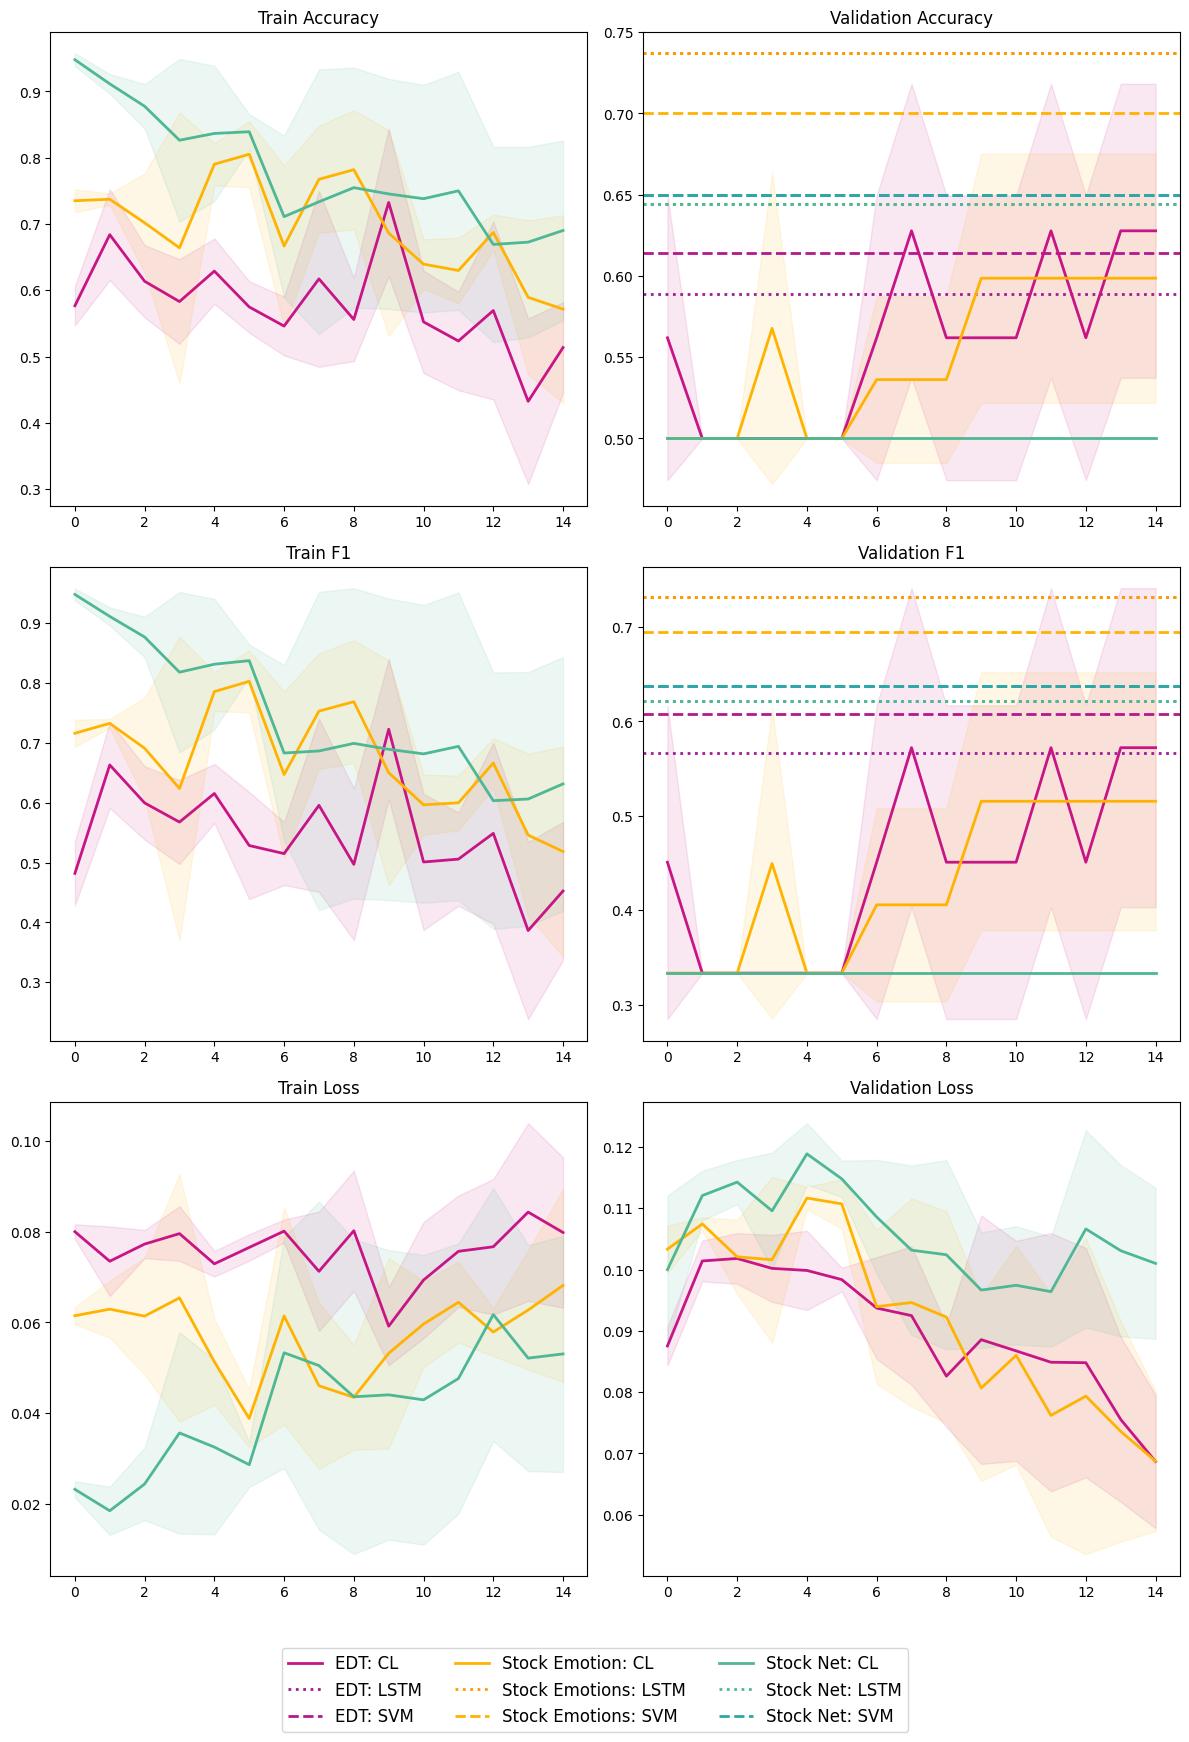

In [65]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load the JSON file data
file_path = "./results/epsilon_transdis/final_training.json"
with open(file_path, "r") as file:
    data = json.load(file)

# Define color sets for each dataset
color_sets = {
    'stock_net': ['#0d98ba', '#2da7a7', '#4eb794', '#6ec681'],
    'EDT': ['#c71585', '#b2198d', '#9e1d96', '#8a229e'],
    'stock_emotion': ['#ffcc00', '#ffb300', '#ff9900', '#ff7f00']
}

# Helper function to make dataset and model params hashable, excluding random_state
def make_params_key(entry):
    dataset_params = entry["dataset_params"].copy()
    model_params = entry["model_params"].copy()
    
    # Remove 'random_state' from both parameter dictionaries
    dataset_params.pop("random_state", None)
    model_params.pop("random_state", None)
    
    # Convert nested dicts/lists to tuples to make the key hashable
    def convert_to_hashable(item):
        if isinstance(item, dict):
            return tuple((k, convert_to_hashable(v)) for k, v in sorted(item.items()))
        elif isinstance(item, list):
            return tuple(convert_to_hashable(x) for x in item)
        return item
    
    return (convert_to_hashable(dataset_params), convert_to_hashable(model_params))

# Calculate mean, variance, and standard deviation
def compute_run_stats(runs):
    stats = {}
    metrics = ['accuracy', 'f1', 'loss']
    for metric in metrics:
        train_values = np.array([entry['train_metrics'][metric] for entry in runs])
        val_values = np.array([entry['val_metrics'][metric] for entry in runs])
        
        stats[f'train_{metric}_mean'] = np.mean(train_values, axis=0)
        stats[f'train_{metric}_std'] = np.std(train_values, axis=0)
        stats[f'val_{metric}_mean'] = np.mean(val_values, axis=0)
        stats[f'val_{metric}_std'] = np.std(val_values, axis=0)
    
    return stats

# Function to get colors based on the dataset name
def get_dataset_color(dataset_name, idx):
    color_list = color_sets.get(dataset_name, ['#333333'])  # Default color if dataset not in color_sets
    return color_list[idx % len(color_list)]

# Main plotting function
def plot_metrics_with_predefined_colors_and_styles(data, font_size=12, line_width=2):
    # Group runs by all dataset and model params, excluding random_state
    grouped_runs = defaultdict(list)
    for entry in data:
        key = make_params_key(entry)
        grouped_runs[key].append(entry)
    

    # Plotting
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    
    legend_labels = {}
    all_handles = {}  # Collect all handles for axhline and plot lines

    
    for idx, (params_key, runs) in enumerate(grouped_runs.items()):
        # Get dataset name and color for the plot
        dataset_name = runs[0]["dataset_params"]["data_source"]["name"]
        color = get_dataset_color(dataset_name, idx)
        dataset_name_title = dataset_name.replace("_", " ").title() if dataset_name != 'EDT' else dataset_name

        # Collect the three run IDs
        run_ids = ", ".join(str(entry['search_index']) for entry in runs[:3])
        legend_label = f"{dataset_name_title}: CL"
        
        # Calculate mean and variance across runs with different random states
        stats = compute_run_stats(runs)
        
        # Add axhline with distinct colors and styles, and collect their handles for the legend
        # Only add to `all_handles` if the label is not already present
        #accuracy scores
        if 'EDT: SVM' not in all_handles:
            all_handles['EDT: SVM'] = axes[0, 1].axhline(0.614, color='#b2198d', linestyle='--', linewidth=2, label='EDT: SVM')
            all_handles['EDT: SVM'] = axes[1, 1].axhline(0.608, color='#b2198d', linestyle='--', linewidth=2, label='EDT: SVM')
        if 'EDT: LSTM' not in all_handles:
            all_handles['EDT: LSTM'] = axes[0, 1].axhline(0.589, color='#9e1d96', linestyle='dotted', linewidth=2, label='EDT: LSTM')
            all_handles['EDT: LSTM'] = axes[1, 1].axhline(0.566, color='#9e1d96', linestyle='dotted', linewidth=2, label='EDT: LSTM')

        if 'Stock Emotions: SVM' not in all_handles:
            all_handles['Stock Emotions: SVM'] = axes[0, 1].axhline(0.700, color='#ffb300', linestyle='--', linewidth=2, label='Stock Emotions: SVM')
            all_handles['Stock Emotions: SVM'] = axes[1, 1].axhline(0.695, color='#ffb300', linestyle='--', linewidth=2, label='Stock Emotions: SVM')
        if 'LSTM: Stock Emotions' not in all_handles:
            all_handles['Stock Emotions: LSTM'] = axes[0, 1].axhline(0.737, color='#ff9900', linestyle='dotted', linewidth=2, label='Stock Emotions: LSTM')
            all_handles['Stock Emotions: LSTM'] = axes[1, 1].axhline(0.732, color='#ff9900', linestyle='dotted', linewidth=2, label='Stock Emotions: LSTM')

        if 'SVM: Stock Net' not in all_handles:
            all_handles['Stock Net: SVM'] = axes[0, 1].axhline(0.650, color='#2da7a7', linestyle='--', linewidth=2, label='Stock Net: SVM')
            all_handles['Stock Net: SVM'] = axes[1, 1].axhline(0.637, color='#2da7a7', linestyle='--', linewidth=2, label='Stock Net: SVM')
        if 'LSTM: Stock Net' not in all_handles:
            all_handles['Stock Net: LSTM'] = axes[0, 1].axhline(0.644, color='#4eb794', linestyle='dotted', linewidth=2, label='Stock Net: LSTM')
            all_handles['Stock Net: LSTM'] = axes[1, 1].axhline(0.622, color='#4eb794', linestyle='dotted', linewidth=2, label='Stock Net: LSTM')


        # Plot each metric with a consistent color and label only the first instance for the legend
        for i, metric in enumerate(['accuracy', 'f1', 'loss']):
            # Train metrics
            if legend_label not in all_handles:
                train_handle, = axes[i, 0].plot(stats[f'train_{metric}_mean'], label=legend_label, color=color, linewidth=line_width)
                all_handles[legend_label] = train_handle  # Add only the first instance of the label
            else:
                axes[i, 0].plot(stats[f'train_{metric}_mean'], color=color, linewidth=line_width)
                
            axes[i, 0].fill_between(range(len(stats[f'train_{metric}_mean'])), 
                                    stats[f'train_{metric}_mean'] - stats[f'train_{metric}_std'],
                                    stats[f'train_{metric}_mean'] + stats[f'train_{metric}_std'], alpha=0.1, color=color)
            axes[i, 0].set_title(f'Train {metric.capitalize()}')
            
            # Validation metrics
            if legend_label not in all_handles:
                val_handle, = axes[i, 1].plot(stats[f'val_{metric}_mean'], label=legend_label, color=color, linewidth=line_width)
                all_handles[legend_label] = val_handle  # Add only the first instance of the label
            else:
                axes[i, 1].plot(stats[f'val_{metric}_mean'], color=color, linewidth=line_width)
                
            axes[i, 1].fill_between(range(len(stats[f'val_{metric}_mean'])), 
                                    stats[f'val_{metric}_mean'] - stats[f'val_{metric}_std'],
                                    stats[f'val_{metric}_mean'] + stats[f'val_{metric}_std'], alpha=0.1, color=color)
            axes[i, 1].set_title(f'Validation {metric.capitalize()}')

    sorted_handles = sorted(all_handles.items(), key=lambda item: item[0])
    sorted_labels, sorted_handles = zip(*sorted_handles)

    # Create a final legend with unique handles in alphabetical order
    fig.legend(sorted_handles, sorted_labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02), fontsize=font_size)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# Run the function
plot_metrics_with_predefined_colors_and_styles(data)



In [86]:
import json

def rank_by_val_accuracy(json_file_path, target_string):
    # Load the JSON data from the file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Filter the data by dataset_name and rank by val_metrics['accuracy']
    filtered_data = [entry for entry in data if entry['dataset_params']['data_source']['name'] == target_string]
    
    # Rank the filtered data by the highest val_metric accuracy
    ranked_data = sorted(filtered_data, key=lambda x: max(x['val_metrics']['accuracy']), reverse=True)
    
    return ranked_data

# Example usage:
ranked_entries = rank_by_val_accuracy('./results/output_frand_normalized_plotting.json', 'stock_net')
for entry in ranked_entries:
    print(f"Random State: {entry['dataset_params']['random_state']}, Max Val Accuracy: {max(entry['val_metrics']['accuracy'])}")


Random State: 43, Max Val Accuracy: 0.9133574007220217
Random State: 42, Max Val Accuracy: 0.5
Random State: 44, Max Val Accuracy: 0.5
Random State: 42, Max Val Accuracy: 0.5
Random State: 43, Max Val Accuracy: 0.5
Random State: 44, Max Val Accuracy: 0.5
Random State: 42, Max Val Accuracy: 0.5
Random State: 43, Max Val Accuracy: 0.5
Random State: 42, Max Val Accuracy: 0.5
Random State: 43, Max Val Accuracy: 0.5
Random State: 44, Max Val Accuracy: 0.5
Random State: 42, Max Val Accuracy: 0.5
Random State: 43, Max Val Accuracy: 0.5
Random State: 44, Max Val Accuracy: 0.5
Random State: 42, Max Val Accuracy: 0.5
Random State: 43, Max Val Accuracy: 0.5
Random State: 44, Max Val Accuracy: 0.5
Random State: 42, Max Val Accuracy: 0.5
Random State: 43, Max Val Accuracy: 0.5
Random State: 44, Max Val Accuracy: 0.5
Random State: 42, Max Val Accuracy: 0.5
Random State: 43, Max Val Accuracy: 0.5
Random State: 44, Max Val Accuracy: 0.5
Random State: 42, Max Val Accuracy: 0.5
Random State: 43, Max Val

In [20]:
import json
from collections import defaultdict
from statistics import mean

def convert_to_hashable(obj):
    """Convert nested dicts and lists to a hashable tuple representation."""
    if isinstance(obj, dict):
        return tuple((k, convert_to_hashable(v)) for k, v in sorted(obj.items()))
    elif isinstance(obj, list):
        return tuple(convert_to_hashable(x) for x in obj)
    return obj

def tuple_to_dict(tpl):
    """Convert a hashable tuple back to a dictionary."""
    if isinstance(tpl, tuple):
        if all(isinstance(i, tuple) and len(i) == 2 for i in tpl):
            return {k: tuple_to_dict(v) for k, v in tpl}
        else:
            return [tuple_to_dict(v) for v in tpl]  # If not key-value pairs, treat as list elements
    return tpl

def find_best_results(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    
    # Group results by dataset_name and dataset_params (excluding random_state)
    results_by_dataset = defaultdict(lambda: defaultdict(lambda: {
        'validation_accuracy': [], 'validation_f1': [], 'test_accuracy': [], 'test_f1': [], 'model_params': None
    }))

    for entry in data:
        dataset_name = entry["dataset_params"].get("data_source", {}).get("name", "unknown")
        dataset_params = entry["dataset_params"].copy()
        dataset_params.pop("random_state", None)  # Exclude random_state
        
        # Create a unique, hashable key for each dataset_params config
        key = convert_to_hashable(dataset_params)

        # Store validation and test results by dataset_name and params
        results_by_dataset[dataset_name][key]['validation_accuracy'].append(entry["results"]["validation"]["accuracy"])
        results_by_dataset[dataset_name][key]['validation_f1'].append(entry["results"]["validation"]["f1_score"])
        results_by_dataset[dataset_name][key]['test_accuracy'].append(entry["results"]["test"]["accuracy"])
        results_by_dataset[dataset_name][key]['test_f1'].append(entry["results"]["test"]["f1_score"])
        
        # Store model params (assuming they are the same for each dataset_params config)
        results_by_dataset[dataset_name][key]['model_params'] = entry["model_params"]

    # Calculate the average results and find the best results for each dataset
    best_results_by_dataset = {}
    for dataset_name, results_by_params in results_by_dataset.items():
        averaged_results = {}
        for params, results in results_by_params.items():
            # Calculate the averages
            averaged_results[params] = {
                "avg_validation_accuracy": mean(results["validation_accuracy"]),
                "avg_validation_f1": mean(results["validation_f1"]),
                "avg_test_accuracy": mean(results["test_accuracy"]),
                "avg_test_f1": mean(results["test_f1"]),
                "model_params": results["model_params"],  # Include model params
            }

        # Find the best validation and test results for each dataset
        best_validation = max(averaged_results, key=lambda x: averaged_results[x]["avg_validation_accuracy"])
        best_test = max(averaged_results, key=lambda x: averaged_results[x]["avg_test_accuracy"])

        # Store the best results for each dataset_name
        best_results_by_dataset[dataset_name] = {
            "best_validation_params": tuple_to_dict(best_validation),
            "best_validation_results": averaged_results[best_validation],
            "best_test_params": tuple_to_dict(best_test),
            "best_test_results": averaged_results[best_test]
        }

    return best_results_by_dataset

# Usage
result = find_best_results("./results/baselines/lstm.json")
for dataset_name, results in result.items():
    print(f"Best Validation Results for {dataset_name}:", results["best_validation_results"])
    print(f"Best Test Results for {dataset_name}:", results["best_test_results"])
    print(f"Model Parameters for {dataset_name}:", results["best_validation_results"]["model_params"])



Best Validation Results for EDT: {'avg_validation_accuracy': 0.589073449960405, 'avg_validation_f1': 0.5658316030293095, 'avg_test_accuracy': 0.597956312762138, 'avg_test_f1': 0.579116910525264, 'model_params': {'model': 'lstm', 'lstm_hidden_dim': 128, 'lstm_input_dim': 1, 'dropout_rate': 0.2, 'dense_units': 128, 'epochs': 10, 'batch_size': 16, 'learning_rate': 0.0001, 'max_features': 500}}
Best Test Results for EDT: {'avg_validation_accuracy': 0.589073449960405, 'avg_validation_f1': 0.5658316030293095, 'avg_test_accuracy': 0.597956312762138, 'avg_test_f1': 0.579116910525264, 'model_params': {'model': 'lstm', 'lstm_hidden_dim': 128, 'lstm_input_dim': 1, 'dropout_rate': 0.2, 'dense_units': 128, 'epochs': 10, 'batch_size': 16, 'learning_rate': 0.0001, 'max_features': 500}}
Model Parameters for EDT: {'model': 'lstm', 'lstm_hidden_dim': 128, 'lstm_input_dim': 1, 'dropout_rate': 0.2, 'dense_units': 128, 'epochs': 10, 'batch_size': 16, 'learning_rate': 0.0001, 'max_features': 500}
Best Valid

In [35]:
import json
from collections import defaultdict
from statistics import mean, stdev

def convert_to_hashable(obj):
    """Convert nested dicts and lists to a hashable tuple representation."""
    if isinstance(obj, dict):
        return tuple((k, convert_to_hashable(v)) for k, v in sorted(obj.items()))
    elif isinstance(obj, list):
        return tuple(convert_to_hashable(x) for x in obj)
    return obj

def tuple_to_dict(tpl):
    """Convert a hashable tuple back to a dictionary."""
    if isinstance(tpl, tuple):
        if all(isinstance(i, tuple) and len(i) == 2 for i in tpl):
            return {k: tuple_to_dict(v) for k, v in tpl}
        else:
            return [tuple_to_dict(v) for v in tpl]  # If not key-value pairs, treat as list elements
    return tpl

def find_best_results(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    
    # Group results by dataset_name and dataset_params (excluding random_state)
    results_by_dataset = defaultdict(lambda: defaultdict(lambda: {
        'validation_accuracy': [], 'validation_f1': [], 'test_accuracy': [], 'test_f1': [], 'model_params': None
    }))

    for entry in data:
        dataset_name = entry["dataset_params"].get("data_source", {}).get("name", "unknown")
        dataset_params = entry["dataset_params"].copy()
        dataset_params.pop("random_state", None)  # Exclude random_state
        
        # Create a unique, hashable key for each dataset_params config
        key = convert_to_hashable(dataset_params)

        # Store validation and test results by dataset_name and params
        results_by_dataset[dataset_name][key]['validation_accuracy'].append(entry["results"]["validation"]["accuracy"])
        results_by_dataset[dataset_name][key]['validation_f1'].append(entry["results"]["validation"]["f1_score"])
        results_by_dataset[dataset_name][key]['test_accuracy'].append(entry["results"]["test"]["accuracy"])
        results_by_dataset[dataset_name][key]['test_f1'].append(entry["results"]["test"]["f1_score"])
        
        # Store model params (assuming they are the same for each dataset_params config)
        results_by_dataset[dataset_name][key]['model_params'] = entry["model_params"]

    # Calculate the average and standard deviation results and find the best results for each dataset
    best_results_by_dataset = {}
    for dataset_name, results_by_params in results_by_dataset.items():
        averaged_results = {}
        for params, results in results_by_params.items():
            # Calculate the averages and standard deviations
            averaged_results[params] = {
                "avg_validation_accuracy": mean(results["validation_accuracy"]),
                "std_validation_accuracy": stdev(results["validation_accuracy"]) if len(results["validation_accuracy"]) > 1 else 0,
                "avg_validation_f1": mean(results["validation_f1"]),
                "std_validation_f1": stdev(results["validation_f1"]) if len(results["validation_f1"]) > 1 else 0,
                "avg_test_accuracy": mean(results["test_accuracy"]),
                "std_test_accuracy": stdev(results["test_accuracy"]) if len(results["test_accuracy"]) > 1 else 0,
                "avg_test_f1": mean(results["test_f1"]),
                "std_test_f1": stdev(results["test_f1"]) if len(results["test_f1"]) > 1 else 0,
                "model_params": results["model_params"],  # Include model params
            }

        # Find the best validation and test results for each dataset
        best_validation = max(averaged_results, key=lambda x: averaged_results[x]["avg_validation_accuracy"])
        best_test = max(averaged_results, key=lambda x: averaged_results[x]["avg_test_accuracy"])

        # Store the best results for each dataset_name
        best_results_by_dataset[dataset_name] = {
            "best_validation_params": tuple_to_dict(best_validation),
            "best_validation_results": averaged_results[best_validation],
            "best_test_params": tuple_to_dict(best_test),
            "best_test_results": averaged_results[best_test]
        }

    return best_results_by_dataset

# Usage
result = find_best_results("./results/baselines/svm.json")
for dataset_name, results in result.items():
    print(f"Best Validation Results for {dataset_name}:", results["best_validation_results"])
    print(f"Best Test Results for {dataset_name}:", results["best_test_results"])
    print(f"Model Parameters for {dataset_name}:", results["best_validation_results"]["model_params"])


Best Validation Results for EDT: {'avg_validation_accuracy': 0.6141895700922777, 'std_validation_accuracy': 0.06159975311803355, 'avg_validation_f1': 0.6084517497063159, 'std_validation_f1': 0.06579247836065104, 'avg_test_accuracy': 0.6181345423092995, 'std_test_accuracy': 0.061016940790011576, 'avg_test_f1': 0.6126858742645971, 'std_test_f1': 0.06362404412077982, 'model_params': {'model': 'svm', 'kernel': 'rbf', 'max_features': 500, 'C': 100}}
Best Test Results for EDT: {'avg_validation_accuracy': 0.6141895700922777, 'std_validation_accuracy': 0.06159975311803355, 'avg_validation_f1': 0.6084517497063159, 'std_validation_f1': 0.06579247836065104, 'avg_test_accuracy': 0.6181345423092995, 'std_test_accuracy': 0.061016940790011576, 'avg_test_f1': 0.6126858742645971, 'std_test_f1': 0.06362404412077982, 'model_params': {'model': 'svm', 'kernel': 'rbf', 'max_features': 500, 'C': 100}}
Model Parameters for EDT: {'model': 'svm', 'kernel': 'rbf', 'max_features': 500, 'C': 100}
Best Validation R